# MFE selecting data
This script uses the API from copernicus to automatically download data over a specific area and then save only the pixels under the shape defined by the user

## Imports

In [31]:
import geopandas as gpd
import os
import requests
import osgeo
import rasterio as rio
import matplotlib.pyplot as plt
import numpy as np
import glob
import pandas as pd
import ipywidgets as widgets

## Open json files
The user needs to define a geojson file, this file will then be compared with the data on Copernicus as a filter for selecting data. Enter the path to the geojson file below or leave empty to select default file

In [11]:
default_json_path = os.path.join("sections_mfe", "buffers", "A43_33_44_short.geojson")
json_path_widgets = widgets.Text(value=default_json_path)
display(json_path_widgets)

Text(value='sections_mfe/buffers/A43_33_44_short.geojson')

### Formatting dataframe geometry
The query requires a specific format for the geometry field, the code below :
1. Opens the geojson
2. Sets the geometry `EPSG:4326`, this is required by Copernicus API
3. Extracts the geometry to `first_geometry_wkt`

In [29]:
def show_road(show = False):
    if show:
        return gdf.explore()

json_path = json_path_widgets.value
gdf = gpd.read_file(json_path)
gdf.crs = 'EPSG:4326'
ddf = gdf.set_crs('EPSG:4326', allow_override = True)
gdf_exploded = gdf.explode(index_parts=True)

# Keep only the first geometry for each feature
gdf_first_geometry = gdf_exploded.groupby(level=0).first()
first_geometry_wkt = gdf_first_geometry.geometry.iloc[0].wkt

# Create drop down list to choose to display the road
widgets.interact(show_road, show = [True, False])

interactive(children=(Dropdown(description='show', index=1, options=(True, False), value=False), Output()), _d…

<function __main__.show_road(show=False)>

## Creating the query
The first part of the query is the geometry defined above. There are other parameters that can be used to filter the data such as: 
1. Cloud cover in %
2. Sensor type
3. Start date and end date

> If the response returns nothing, make the geometry shorter

In [66]:
# TODO: add GUI elements to change these parameter
start_date_year = 2015
end_date_year = 2017
sensor = "SENTINEL-2"
cloud_cover = 20 # between 0~100%

In [67]:
import requests
import pandas as pd
# Define the URL with the query parameters
# url = "https://catalogue.dataspace.copernicus.eu/odata/v1/Products?$filter=OData.CSC.Intersects(area=geography'SRID=4326;{}') and Collection/Name eq {} and ContentDate/Start gt {}-01-01T00:00:00.000Z and ContentDate/Start lt {}-06-01T00:00:00.000Z and Attributes/OData.CSC.DoubleAttribute/any(att:att/Name eq 'cloudCover' and att/OData.CSC.DoubleAttribute/Value lt {})".format(first_geometry_wkt, sensor, start_date_year, end_date_year, cloud_cover)
url = "https://catalogue.dataspace.copernicus.eu/odata/v1/Products?$filter=OData.CSC.Intersects(area=geography'SRID=4326;{}') and Collection/Name eq 'SENTINEL-2' and ContentDate/Start gt 2015-01-01T00:00:00.000Z and ContentDate/Start lt 2022-06-01T00:00:00.000Z and Attributes/OData.CSC.DoubleAttribute/any(att:att/Name eq 'cloudCover' and att/OData.CSC.DoubleAttribute/Value lt 20.00)".format(first_geometry_wkt)
url = "https://catalogue.dataspace.copernicus.eu/odata/v1/Products?$filter=OData.CSC.Intersects(area=geography'SRID=4326;{}') and Collection/Name eq '{}' and ContentDate/Start gt {}-01-01T00:00:00.000Z and ContentDate/Start lt {}-06-01T00:00:00.000Z and Attributes/OData.CSC.DoubleAttribute/any(att:att/Name eq 'cloudCover' and att/OData.CSC.DoubleAttribute/Value lt {})".format(first_geometry_wkt, sensor, start_date_year, end_date_year, cloud_cover)
# Make the GET request
response = requests.get(url).json()
#response

In [47]:
df = pd.DataFrame.from_dict(response['value'])
df

,@odata.mediaContentType,Id,Name,ContentType,ContentLength,OriginDate,PublicationDate,ModificationDate,Online,EvictionDate,S3Path,Checksum,ContentDate,Footprint,GeoFootprint
0,application/octet-stream,8ef1d1b2-7eb9-5b44-afb0-374b6f023f52,S2A_MSIL1C_20160319T104032_N0201_R008_T31TFL_2...,application/octet-stream,0,2018-12-04T19:43:53.704Z,2018-12-04T23:18:49.976Z,2018-12-04T23:18:49.976Z,True,,/eodata/Sentinel-2/MSI/L1C/2016/03/19/S2A_MSIL...,[],"{'Start': '2016-03-19T10:40:32.031Z', 'End': '...",geography'SRID=4326;POLYGON ((4.2925320358333 ...,"{'type': 'Polygon', 'coordinates': [[[4.292532..."
1,application/octet-stream,95a65d95-6ba0-554c-be2d-849a72e7090d,S2A_MSIL1C_20150812T104026_N0204_R008_T31TFL_2...,application/octet-stream,0,2019-02-04T23:21:49.727Z,2019-02-04T21:41:33.143Z,2019-02-04T21:41:33.143Z,True,,/eodata/Sentinel-2/MSI/L1C/2015/08/12/S2A_MSIL...,[],"{'Start': '2015-08-12T10:40:26.027Z', 'End': '...",geography'SRID=4326;POLYGON ((4.2925320358333 ...,"{'type': 'Polygon', 'coordinates': [[[4.292532..."
2,application/octet-stream,6b7c8e70-587f-59a6-8d8f-61e0f5bdaf54,S2A_MSIL1C_20150819T103026_N0204_R108_T31TFL_2...,application/octet-stream,0,2019-02-04T19:45:38.153Z,2019-09-10T06:53:36.222Z,2019-09-10T06:53:36.222Z,True,,/eodata/Sentinel-2/MSI/L1C/2015/08/19/S2A_MSIL...,[],"{'Start': '2015-08-19T10:30:26.027Z', 'End': '...",geography'SRID=4326;POLYGON ((4.6254202643651 ...,"{'type': 'Polygon', 'coordinates': [[[4.625420..."
3,application/octet-stream,3c77dbf6-7dc7-588d-8a2f-1583afdb8365,S2A_MSIL1C_20150829T103026_N0204_R108_T31TFL_2...,application/octet-stream,0,2019-01-31T17:14:36.418Z,2019-09-09T21:28:13.067Z,2019-09-09T21:28:13.067Z,True,,/eodata/Sentinel-2/MSI/L1C/2015/08/29/S2A_MSIL...,[],"{'Start': '2015-08-29T10:30:26.027Z', 'End': '...",geography'SRID=4326;POLYGON ((4.6295213282336 ...,"{'type': 'Polygon', 'coordinates': [[[4.629521..."
4,application/octet-stream,45fede72-d539-5a7d-a87d-7670546a6435,S2A_MSIL2A_20150918T103036_N0204_R108_T31TFL_2...,application/octet-stream,852367161,2023-01-07T15:07:47.616Z,2023-01-07T17:33:15.061Z,2023-01-07T17:33:21.542Z,True,,/eodata/Sentinel-2/MSI/L2A/2015/09/18/S2A_MSIL...,[{}],"{'Start': '2015-09-18T10:30:36.028Z', 'End': '...",geography'SRID=4326;POLYGON ((4.61255791241797...,"{'type': 'Polygon', 'coordinates': [[[4.612557..."
5,application/octet-stream,0735f11b-aa8b-51cd-bc01-b0d8df547893,S2A_MSIL2A_20151227T103442_N0201_R108_T31TFL_2...,application/octet-stream,868510922,2023-01-13T02:00:42.742Z,2023-01-13T03:55:51.805Z,2023-01-13T03:55:57.506Z,True,,/eodata/Sentinel-2/MSI/L2A/2015/12/27/S2A_MSIL...,[{}],"{'Start': '2015-12-27T10:34:42.030Z', 'End': '...",geography'SRID=4326;POLYGON ((4.29253204 46.04...,"{'type': 'Polygon', 'coordinates': [[[4.292532..."
6,application/octet-stream,fdaa415f-3dbf-52c2-9886-087a38238cc1,S2A_MSIL2A_20150802T104026_N0204_R008_T31TFL_2...,application/octet-stream,1341588247,2023-01-05T07:14:51.171Z,2023-01-05T09:35:45.524Z,2023-01-05T09:35:50.714Z,True,,/eodata/Sentinel-2/MSI/L2A/2015/08/02/S2A_MSIL...,[{}],"{'Start': '2015-08-02T10:40:26.027Z', 'End': '...",geography'SRID=4326;POLYGON ((4.2925320358333 ...,"{'type': 'Polygon', 'coordinates': [[[4.292532..."
7,application/octet-stream,b6aff88d-f012-56d8-882d-eac4431968f9,S2A_MSIL1C_20150802T104026_N0204_R008_T31TFL_2...,application/octet-stream,0,2019-02-05T03:53:26.311Z,2019-09-09T22:47:05.924Z,2019-09-09T22:47:05.924Z,True,,/eodata/Sentinel-2/MSI/L1C/2015/08/02/S2A_MSIL...,[],"{'Start': '2015-08-02T10:40:26.027Z', 'End': '...",geography'SRID=4326;POLYGON ((4.2925320358333 ...,"{'type': 'Polygon', 'coordinates': [[[4.292532..."
8,application/octet-stream,5928f1f7-93fe-5688-aaaa-a678eea1b0f0,S2A_MSIL2A_20150819T103026_N0204_R108_T31TFL_2...,application/octet-stream,847853307,2023-01-05T23:02:45.322Z,2023-01-06T01:07:35.922Z,2023-01-06T01:07:40.772Z,True,,/eodata/Sentinel-2/MSI/L2A/2015/08/19/S2A_MSIL...,[{}],"{'Start': '2015-08-19T10:30:26.027Z', 'End': '...",geography'SRID=4326;POLYGO

### Next values
There is a link at the end of data to get another 20 values

In [ ]:
start_search_url = "https://catalogue.dataspace.copernicus.eu/odata/v1/Products?$filter=OData.CSC.Intersects(area=geography'SRID=4326;{}') and Collection/Name eq '{}' and ContentDate/Start gt {}-01-01T00:00:00.000Z and ContentDate/Start lt {}-06-01T00:00:00.000Z and Attributes/OData.CSC.DoubleAttribute/any(att:att/Name eq 'cloudCover' and att/OData.CSC.DoubleAttribute/Value lt {})".format(first_geometry_wkt, sensor, start_date_year, end_date_year, cloud_cover)
url = start_search_url
dfs = []
while True: 
    response = requests.get(url).json()
    try:
        next_value = response['@odata.nextLink']
        url = r"{}".format(next_value)
        dfs.append(pd.DataFrame.from_dict(response['value']))
    except:
        dfs.append(pd.DataFrame.from_dict(response['value']))
        break
df = pd.concat(dfs)
df.reset_index(inplace=True)

### Double checking geometries
Some of the data returned does not actually overlap our our geometries properly

In [26]:
## Todo add a second geometry filter

## Getting access tokens
The API requires an access token, the code below generates it

In [46]:
pass_path = os.path.join("mydata", "pass.txt")
with open(pass_path, "r") as f:
    email = f.readline()
    password = f.readline()
    # Define the endpoint and payload
    url = "https://identity.dataspace.copernicus.eu/auth/realms/CDSE/protocol/openid-connect/token"
    payload = {
        "username": email.strip(),
        "password": password.strip(),
        "grant_type": "password",
        "client_id": "cdse-public"
    }
    
    # Make the HTTP POST request
    response = requests.post(url, data=payload, headers={"Content-Type": "application/x-www-form-urlencoded"})
    
    
    data = response.json()
    access_token = data.get("access_token")
    print(access_token)

eyJhbGciOiJSUzI1NiIsInR5cCIgOiAiSldUIiwia2lkIiA6ICJYVUh3VWZKaHVDVWo0X3k4ZF8xM0hxWXBYMFdwdDd2anhob2FPLUxzREZFIn0.eyJleHAiOjE3MDkyOTA2NjIsImlhdCI6MTcwOTI5MDA2MiwianRpIjoiNTE3MDE4YjQtZWI4MC00OGFiLTlkZjAtYjNiZjYyNGZhZjE1IiwiaXNzIjoiaHR0cHM6Ly9pZGVudGl0eS5kYXRhc3BhY2UuY29wZXJuaWN1cy5ldS9hdXRoL3JlYWxtcy9DRFNFIiwiYXVkIjpbIkNMT1VERkVSUk9fUFVCTElDIiwiYWNjb3VudCJdLCJzdWIiOiI0ZDkwMjg0Ni04ZjU0LTRhMjQtYTMwNi0xNzVkNTM1MjRlMTAiLCJ0eXAiOiJCZWFyZXIiLCJhenAiOiJjZHNlLXB1YmxpYyIsInNlc3Npb25fc3RhdGUiOiJiMzM5MGI1Mi0wZmU4LTQ3ZDgtYTc0Ni1iYjg0Nzc0MWY0NjgiLCJhbGxvd2VkLW9yaWdpbnMiOlsiaHR0cHM6Ly9sb2NhbGhvc3Q6NDIwMCIsIioiLCJodHRwczovL3dvcmtzcGFjZS5zdGFnaW5nLWNkc2UtZGF0YS1leHBsb3Jlci5hcHBzLnN0YWdpbmcuaW50cmEuY2xvdWRmZXJyby5jb20iXSwicmVhbG1fYWNjZXNzIjp7InJvbGVzIjpbIm9mZmxpbmVfYWNjZXNzIiwidW1hX2F1dGhvcml6YXRpb24iLCJkZWZhdWx0LXJvbGVzLWNkYXMiLCJjb3Blcm5pY3VzLWdlbmVyYWwiXX0sInJlc291cmNlX2FjY2VzcyI6eyJhY2NvdW50Ijp7InJvbGVzIjpbIm1hbmFnZS1hY2NvdW50IiwibWFuYWdlLWFjY291bnQtbGlua3MiLCJ2aWV3LXByb2ZpbGUiXX19LCJzY29wZSI6IkFVRElF

# Downloading data

Now that we have ID selected using geographical data and access tokens we can procceed to the installation

In [23]:
output_file_location = "product.zip"
import shutil
# delete existing files
try:
    os.remove(output_file_location)
except:
    print("{} does not exist, moving on".format(output_file_location))

try: 
    sisi_path = os.path.join(os.getcwd(), "sisi")
    shutil.rmtree(sisi_path)
except: 
    print("Sisi file does not exist, moving on")

In [24]:
import requests
import tqdm
myid = df.loc[1, "Id"]
url = f"https://zipper.dataspace.copernicus.eu/odata/v1/Products({myid})/$value"

headers = {"Authorization": f"Bearer {access_token}"}

session = requests.Session()
session.headers.update(headers)
response = session.get(url, headers=headers, stream=True)


with open(output_file_location, "wb") as file:
    for chunk in tqdm.tqdm(response.iter_content(chunk_size=8192)):
        if chunk:
            file.write(chunk)

74651it [00:52, 1411.35it/s]


# Opening data
Because only a small part of the data is interesting, we need to trim the images to only keep the pixels that are under our mask. This will allow us to save place

In [25]:
# we start by unzipping the file
import zipfile
path_to_unzipped_file = "sisi"
with zipfile.ZipFile(output_file_location, 'r') as zip_ref:
    zip_ref.extractall(path_to_unzipped_file)

In [2]:
l = glob.glob("sisi/*/GRANULE/*/IMG_DATA/*")
l.sort()

In [3]:
gdf = gpd.read_file(json_path)
gdf=gdf.to_crs("EPSG:32631")
#gdf.explore()

NameError: name 'json_path' is not defined

EPSG:32631


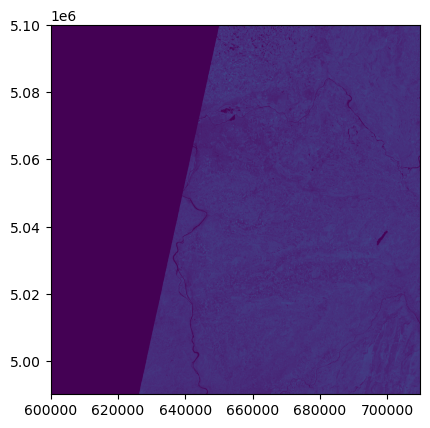

In [30]:
import matplotlib.pyplot as plt
fig, axs = plt.subplots()
src = rio.open(l[6])
extent = [src.bounds[0], src.bounds[2], src.bounds[1], src.bounds[3]]
#extent = [src.bounds[1], src.bounds[3], src.bounds[0], src.bounds[2]]
# axs = rio.plot.show(src.read(1), extent=extent, cmap='viridis')
plt.imshow(src.read(1), extent=extent)

print(src.crs)
gdf.plot(ax=axs)
# ax
plt.show()

# Snipping raster by mask

In [31]:
# looping through the images
srcs = []
extents = []
for selection in l[2:3]:
    src = rio.open(
	    selection
	)
    srcs.append(src)
    extents.append(
	    [src.bounds[0], src.bounds[2], src.bounds[1], src.bounds[3]]
	)

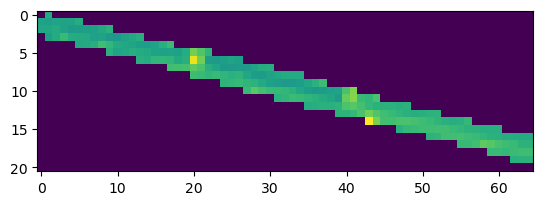

In [32]:
from rasterio import mask
clipped_bands = []
for num, src in enumerate(srcs): 
    out_image, out_transform = rio.mask.mask(
	    src, 
	    gdf.geometry, 
	    crop=True
	)
    clipped_bands.append(np.squeeze(out_image))
clipped_stacked = np.stack(clipped_bands, axis=0)
plt.imshow(clipped_stacked[0, :, :])

In [12]:
import os
from glob import glob
import matplotlib.pyplot as plt
import earthpy as et
import earthpy.spatial as es
import earthpy.plot as ep

ModuleNotFoundError: No module named 'earthpy'

In [ ]:
gdf.plot()